In [2]:
import rf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from datetime import datetime
from collections import defaultdict
import pygmt
import random

import warnings
warnings.filterwarnings("ignore")


In [3]:
def peak_delay(trace: rf.rfstream.RFTrace) -> float:
    return trace.times()[np.argmax(trace.data)] - (
        trace.stats.onset - trace.stats.starttime
    )


def quality_filter(
    stream: rf.RFStream, starttime: int = -5, endtime: int = 10
) -> rf.RFStream:
    """ "
    Applies various final quality controlls to the RFs
    starttime and end time are in seconds relative to onset
    """
    # Drop transverse component
    stream = stream.select(channel="??R")

    # Trim to a reasonable time length
    stream = stream.trim2(starttime, endtime, reftime="onset")

    # Only keep traces with the expected length
    # is this sampling rate correct?
    expected_trace_length = int(stream[0].stats.sampling_rate) * (endtime - starttime) + 1
    for trace in stream:
        if len(trace) != expected_trace_length:
            stream.remove(trace)

    # Count initial number of stations
    nstations = len(stream.stack())

    initial_number = len(stream)
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        # Only keep traces where largest arrival is positive
        if trace[np.argmax(np.abs(trace.data))] < 0:
            continue
        # Only keep traces where largest arrival is within 2 seconds
        if peak_delay(trace) > 2:
            continue
        # Only keep traces with slope_ratio > 5
        if trace.stats.slope_ratio < 5:
            continue
        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # Only keep stations with 10 or more traces
    rf_station_dict = {
        k: v.sort(["back_azimuth"]) for k, v in rf_station_dict.items() if len(v) >= 10
    }

    final_number = 0
    for v in rf_station_dict.values():
        final_number += len(v)
    print(
        f"{len([v for v in rf_station_dict.values() if len(v) > 0])}/{nstations} stations kept after quality control"
    )
    print(f"{final_number}/{initial_number} radial RFs kept after quality control")
    return sum(rf_station_dict.values(), start=rf.RFStream())


def plot_map(stream: rf.RFStream, save_dir="."):
    region = [112, 155, -46, -8]
    ln_min, ln_max, lt_min, lt_max = region
    projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/15c"

    lats = np.zeros(len(stream), dtype=float)
    lons = np.zeros_like(lats, dtype=float)
    nets = np.zeros_like(lats, dtype=str)
    delays = np.zeros_like(lats, dtype=float)

    for i, trace in enumerate(stream):
        lats[i] = trace.meta.station_latitude
        lons[i] = trace.meta.station_longitude
        nets[i] = trace.meta.network
        delays[i] = trace.stats.delay

    fig = pygmt.Figure()
    fig.basemap(region=region, projection=projection, frame=True)
    fig.coast(region=region, projection=projection, shorelines=1, land="#ffffe6", water="#e6ffff", borders="2/1p,grey")

    pygmt.makecpt(cmap="dem3", series=[0, 2])

    fig.plot(region=region, projection=projection, 
        x=lons,
        y=lats,
        style=f"tc",
        pen="1p",
        fill=delays,
        cmap=True,
        size=np.full_like(lons, 0.3),
    )
    fig.colorbar(region=region, projection=projection, frame="af+lDelay Time TPsb (s)")
    if save_dir is not None:
        mapfile = os.path.join(save_dir, "delay_map.pdf")
        fig.savefig(mapfile)


In [4]:
# Get list of networks for which we have RFs
try:
    dataroot = os.environ["NB_ARGS"]
except KeyError:
    dataroot = "rf_data"
networks = [
    net[:2]
    for net in os.listdir(dataroot)
    if len(net.split("-")[0]) == 2 and net.split("-")[1] == "analysis"
]

In [7]:
dry_run = False
# Make output directories
if not dry_run:
    now = (datetime.now()).strftime(format="%Y%m%d_%H%M%S")
    processedroot = os.path.join(dataroot, "processed")
    for net in networks:
        os.makedirs(os.path.join(processedroot, now, net))

6C
13/16 stations kept after quality control
183/1028 radial RFs kept after quality control


TypeError: 'NoneType' object is not iterable

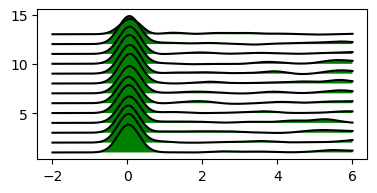

In [9]:
# Grab the latest receiver functions from each network
rfstream = rf.RFStream()  # Stream with every RF
rfstacks = rf.RFStream()  # Stream with station stacks
for net in networks:
    print(net)
    network_dir = os.path.join(dataroot, f"{net}-analysis")
    outdir = os.path.join(processedroot, now, net) if not dry_run else None
    try:
        latest_run = max(
            [
                os.path.join(network_dir, d)
                for d in os.listdir(network_dir)
                if os.path.isdir(os.path.join(network_dir, d))
            ],
            key=os.path.getmtime,
        )
    except ValueError as e:
        print(f"No run found for network {net}.")
        continue

    # Grab the latest .h5 file - should be the outputs of qc
    try:
        h5_file = max(
            [
                os.path.join(latest_run, f)
                for f in os.listdir(latest_run)
                if os.path.splitext(f)[1] == ".h5"
            ],
            key=os.path.getmtime,
        )
    except ValueError as e:
        print(f"No run found for network {net}.")
        continue

    try:
        stream = rf.read_rf(h5_file, format='h5')
    except:
        print(f"Something went wrong when reading {h5_file}. Moving on...")
        continue
    stream = quality_filter(stream)
    if len(stream) == 0:
        print(f"Nothing left after quality control for network {net}. Moving on...")
        continue
    rfstream += stream

    # Station dictionary
    rf_station_dict = defaultdict(rf.RFStream)
    stacks = rf.RFStream()
    for trace in stream:
        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # stack stations individually, otherwise station coordinates also get stacked
    for v in rf_station_dict.values():
        stacks += v.stack()

    # Get delay of each stack
    for trace in stacks:
        trace.stats["delay"] = peak_delay(trace)
    stacks = stacks.sort(["delay"])
    rfstacks += stacks

    if not dry_run:
        # plot RFs at each station
        for k, v in rf_station_dict.items():
            plot_name = os.path.join(outdir, f"{k}.pdf")
            fig = v.plot_rf(fname=plot_name,
                fig_width=4,
                fillcolors=("green", None),
                trace_height=0.1,
                scale=3,
                show_vlines=True,
                trim=(-2, 6),
            )  # this figure needs some bits to be moved around

        # Plot the stacked RFs of the network
        plot_name = os.path.join(outdir, f"stacks.pdf")
        fig = stacks.plot_rf(fname=plot_name,
            fig_width=4,
            fillcolors=("green", None),
            trace_height=0.1,
            scale=3,
            show_vlines=True,
            trim=(-2, 6),
            info=None,
        ) # customise this plot to use a colourmap

        # Plot map of network delay times
        plot_map(stacks, outdir)

In [11]:
plot_name

'rf_data/processed/20230324_095556/6C/stacks.pdf'

In [ ]:
if not dry_run:
    # Plot the full map
    outdir = os.path.join(processedroot, now)
    plot_map(rfstacks, outdir)

    # Save the delay times in txt file
    with open(os.path.join(outdir, "delays.txt"), "w") as f:
        for stack in rfstacks:
            f.write(f"{stack.meta.network:4}\t{stack.meta.station:6}\t{stack.meta.station_longitude}\t{stack.meta.station_latitude}\t{stack.stats.delay:.3f}\n")

    # Save the final RFs and stacks
    rfstream.write(os.path.join(outdir, "rfstream.h5"), format="H5")
    rfstacks.write(os.path.join(outdir, "rfstacks.h5"), format="H5")